# When to use Logistic Regression vs Support Vector Machines vs Naive Bayes classifiers
6/30/2020  

In classification problems, a variety of supervised learning techniques can be used. In this report, we evaluate the benefits and drawbacks of three common classifiers using the MNIST dataset and scikit-learn, a python machine learning library.  

## MNIST Dataset
The MNIST dataset is a collection of 70,000 28x28 pixel grayscale images of handwritten digits (0-9), with each pixel corresponding to an integer between 0 (black) and 255 (white).  

For classification, each pixel will be a feature. Feature scaling is used to constrain features between 0.0 and 1.0. Since the digits are distributed fairly evenly, accuracy can be used to evaluate the model rather than precision, recall, or F1 score.  

The dataset is split into two datasets: one full size dataset (70,000 images), one 10% size dataset (7,000 images)  
Each dataset is split into sets:
* 70% training - train model / set parameters
   * 3-fold cross validation  - tune hyperparameters, plot accuracy to detect underfitting/overfitting
* 30% validation (holdout) - evaluate final classification accuracy

Begin with some imports:

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
import time
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

The full MNIST dataset needs to normalized and split into training and validation sets. We can also show some examples of the handwritten digits in the dataset:

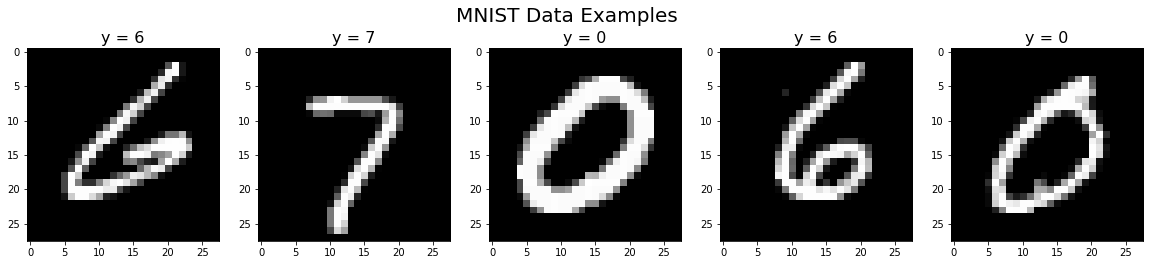

In [2]:
x,y = fetch_openml('mnist_784', return_X_y=True)
x = x/255.0

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

x_throwaway, x_small, y_throwaway, y_small = train_test_split(x, y, test_size=0.1, random_state=0)
x_train_small, x_test_small, y_train_small, y_test_small = train_test_split(x_small, y_small, test_size=0.3, random_state=0)

plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
    plt.plot(1, 5, index + 1)
    plt.subplot(1, 5, index + 1).set_title('y = {}'.format(label),fontsize=16)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
plt.suptitle('MNIST Data Examples',fontsize=20)
plt.show()

## Logistic Regression
Logistic regression is a discriminative model, meaning that it learns the decision boundary between classes. In binary classification, this involves a hypothesis $h_\theta(x)=\frac{1}{1+e^{\theta^Tx}}$ representing the probability $P(y|x)$ that a given data point with features x belongs to class y. The logistic function allows for the probabilistic representation since it restricts y to values between 0 and 1.  

Classification is determined based on the greater probability between $P(y=0|x)$ and $P(y=1|x)$. The decision boundary is created at an equal probability of both classes, which occurs at $h_\theta(x)=0.5$ or $\theta^Tx=0$. Though typically linear, this decision boundary can become non-linear by creating new features that are polynomial terms of previous features.  

A cost function $J(\theta)$ is defined to measure the error in the model's classification accuracy across all training examples. The model minimizes $J(\theta)$ using an optimization algorithm such as gradient descent or L-BFGS in order to find the $\theta$ that results in the lowest cost or greatest classification accuracy. Regularization is applied to address overfitting. An extra term called a penalty is added to $J(\theta)$, though it also introduces a hyperparameter $C$ that needs to be optimized as well.  

In multiclass classification, the one-vs-rest method is used. All classes except for one are grouped together into one class, creating two classes and allowing for binary classification. This process repeats for all individual classes and the model predics the class with the greatest $P(y|x)$.  

We start by finding the best hyperparameters (primarily learning rate) for our logistic regression model using a grid search:

In [3]:
def grid(clf, params):
    time_start = time.clock()
    grid_search = GridSearchCV(error_score='raise',
        estimator = clf,
        iid = True,
        param_grid = params,
        return_train_score = True,
        scoring = None,
        cv = 3) 
    grid_search.fit(x_test, y_test)
    print('Tuning time:', str(round(time.clock()-time_start,3))+'s')
    print('Best parameters:', grid_search.best_params_)

clf = LogisticRegression(penalty='l2', tol=0.001, C=1.0, solver='lbfgs', max_iter=50, multi_class='ovr')
params = {'C':[0.1,0.33,1], 'solver':['lbfgs'], 'tol':[0.001], 'penalty':['l2'], 'max_iter':[50], 'multi_class':['ovr']}
grid(clf, params)


Tuning time: 59.016s
Best parameters: {'C': 0.33, 'max_iter': 50, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.001}


Now we let our model train on a training set, then test its accuracy on a validation set:

In [4]:
def train(clf):
    time_start = time.clock()
    clf.fit(x_train, y_train)
    print('Large dataset:')
    print(u'\u2022','Training time:\t   %.3fs' % round(time.clock()-time_start,3))
    print(u'\u2022','Training set accuracy:   %.3f%%' % round(accuracy_score(y_train,clf.predict(x_train))*100,3))
    print(u'\u2022','Validation set accuracy: %.3f%%' % round(accuracy_score(y_test,clf.predict(x_test))*100,3))
    print("")
def train_small(clf):
    time_start = time.clock()
    clf.fit(x_train_small, y_train_small)
    print('Small dataset:')
    print(u'\u2022','Training time:\t   %.3fs' % round(time.clock()-time_start,3))
    print(u'\u2022','Training set accuracy:   %.3f%%' % round(accuracy_score(y_train_small,clf.predict(x_train_small))*100,3))
    print(u'\u2022','Validation set accuracy: %.3f%%' % round(accuracy_score(y_test_small,clf.predict(x_test_small))*100,3))

log_reg = LogisticRegression(penalty='l2', tol=0.001, C=0.33, solver='lbfgs', max_iter=50, multi_class='ovr')
train(log_reg)
train_small(log_reg)


Large dataset:
• Training time:	   18.075s
• Training set accuracy:   92.627%
• Validation set accuracy: 91.238%

Small dataset:
• Training time:	   2.062s
• Training set accuracy:   94.469%
• Validation set accuracy: 89.905%


To watch for overfitting, we plot the accuracy of both training and validation sets as a function of the number of training epochs. The goal of minimal overfitting should yield similar accuracy for both sets, as shown by the large dataset:

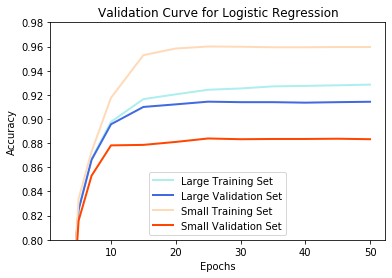

In [5]:
def validation_curves(clf, params, y_low, y_high, name):
    train_scores, test_scores = validation_curve(clf, x_train, y_train, param_name='max_iter', param_range=params, scoring='accuracy', n_jobs=-1, cv=3)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    train_scores_small, test_scores_small = validation_curve(clf, x_train_small, y_train_small, param_name='max_iter', param_range=params, scoring='accuracy', n_jobs=-1, cv=2)
    train_scores_mean_small = np.mean(train_scores_small, axis=1)
    test_scores_mean_small = np.mean(test_scores_small, axis=1)

    plt.title('Validation Curve for '+name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(y_low, y_high)
    plt.plot(params, train_scores_mean, label='Large Training Set', color='paleturquoise', lw=2)
    plt.plot(params, test_scores_mean, label='Large Validation Set', color='royalblue', lw=2)
    plt.plot(params, train_scores_mean_small, label='Small Training Set', color='peachpuff', lw=2)
    plt.plot(params, test_scores_mean_small, label='Small Validation Set', color='orangered', lw=2)
    plt.legend(loc='lower center')
    plt.show()

params = [3,5,7,10,15,20,25,30,35,40,45,50]
log_reg = LogisticRegression(penalty='l2', tol=0.001, C=0.33, solver='lbfgs', multi_class='ovr')
validation_curves(log_reg, params, 0.8, 0.98, 'Logistic Regression')

## Support Vector Machines
A SVM is another discriminative model similar to logistic regression in the sense that they have a similar cost function, with the softmax function being approximated with a linear rectifier. The cost function (with regularization) is also minimized to maximize classification accuracy and the one-vs-rest method is used for multiclass classification.  

A key difference is that SVMs are capable of large margin classification, meaning that they maximize the distance between the data and the decision boundary, which is also called a hyperplane. The hyperplane is defined by support vectors, which are created from points in each class closest to the decision boundary.  

Kernels allow SVMs to perform nonlinear classification by defining new features based on similarity with chosen landmarks, then training based on the same cost function. The similarity function is defined by the kernel, which often adds more hyperparaters such as $\gamma$ in the Gaussian/RBF kernel. When no kernel is used, the model is often referred to as using a linear kernel.  

### Linear Kernel

In [6]:
svm_lin = SVC(C=10, kernel='linear', gamma='scale', tol=0.001, max_iter=50, decision_function_shape='ovr')
train(svm_lin)
train_small(svm_lin)

Large dataset:
• Training time:	   70.645s
• Training set accuracy:   71.510%
• Validation set accuracy: 70.662%

Small dataset:
• Training time:	   4.946s
• Training set accuracy:   92.918%
• Validation set accuracy: 87.524%


### Polynomial Kernel

In [7]:
clf = SVC(C=5.0, kernel='poly', gamma=0.05, tol=0.001, max_iter=50, decision_function_shape='ovr')
params = {'C':[3.33,10,33.33], 'gamma':['scale'], 'kernel':['rbf'], 'tol':[0.001], 'max_iter':[50], 'decision_function_shape':['ovr']}
grid(clf, params)

Tuning time: 873.508s
Best parameters: {'C': 3.33, 'decision_function_shape': 'ovr', 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 50, 'tol': 0.001}


In [8]:
svm_poly = SVC(C=10, kernel='poly', gamma='scale', tol=0.001, max_iter=50, decision_function_shape='ovr')
train(svm_poly)
train_small(svm_poly)

Large dataset:
• Training time:	   72.120s
• Training set accuracy:   83.833%
• Validation set accuracy: 83.129%

Small dataset:
• Training time:	   5.937s
• Training set accuracy:   97.327%
• Validation set accuracy: 91.381%


### RBF Kernel

In [9]:
clf = SVC(C=5.0, kernel='rbf', gamma=0.05, tol=0.001, max_iter=50, decision_function_shape='ovr')
params = {'C':[3.33,10,33.33], 'gamma':['scale'], 'kernel':['rbf'], 'tol':[0.001], 'max_iter':[50], 'decision_function_shape':['ovr']}
grid(clf, params)

Tuning time: 868.069s
Best parameters: {'C': 3.33, 'decision_function_shape': 'ovr', 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 50, 'tol': 0.001}


In [10]:
svm_rbf = SVC(C=10.0, kernel='rbf', gamma='scale', tol=0.001, max_iter=50, decision_function_shape='ovr')
train(svm_rbf)
train_small(svm_rbf)

Large dataset:
• Training time:	   77.170s
• Training set accuracy:   92.659%
• Validation set accuracy: 91.238%

Small dataset:
• Training time:	   6.476s
• Training set accuracy:   99.633%
• Validation set accuracy: 94.714%


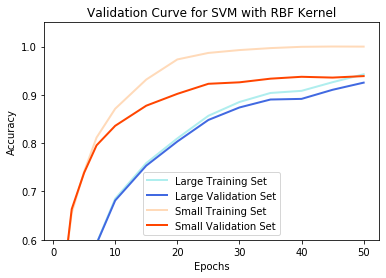

In [11]:
params = [1,3,5,7,10,15,20,25,30,35,40,45,50]
svm_rbf = SVC(C=10.0, kernel='rbf', gamma='scale', tol=0.001, decision_function_shape='ovr')
validation_curves(svm_rbf, params, 0.6, 1.05, 'SVM with RBF Kernel')

## Naive Bayes Classifiers
The Naive Bayes classifier is a generative model, meaning that it models the distribution of individual classes rather than learning a decision boundary. Naive Bayes is based on Bayes' Theorem: $P(y|x) = \frac{P(y)P(x|y)}{P(x)}$  

We can calculate $P(y|x)$ if we make the naive assumption that the features $x_i$ are independent of each other, which very rarely occurs but often works sufficiently in practice. Assuming independence, $P(y|x) = \frac{P(y)\Pi_{i=1}^nP(x_i|y)}{\Pi_{i=1}^nP(x_i)}$. The Naive Bayes classifier then predicts the class $y$ with the highest $P(y|x)$.  

Because the MNIST data contains discrete data (integers), we will use the multinomial Naive Bayes classifier, where class and conditional probabilities are calculated from the training set. 


### Gaussian Naive Bayes
The Gaussian Naive Bayes classifier models continuous-valued features. The MNIST data is technically discrete, but is only forced to be so due to limitations of image representation. In practice, values are essentially continuous.

In [12]:
nb_gaus = GaussianNB()
train(nb_gaus)
train_small(nb_gaus)

Large dataset:
• Training time:	   1.220s
• Training set accuracy:   53.953%
• Validation set accuracy: 54.105%

Small dataset:
• Training time:	   0.137s
• Training set accuracy:   62.776%
• Validation set accuracy: 61.286%


### Multinomial Naive Bayes
The Multinomial Naive Bayes classifier models discrete-valued features.

In [13]:
nb_mult = MultinomialNB(alpha=0)
train(nb_mult)
train_small(nb_mult)

Large dataset:
• Training time:	   0.364s
• Training set accuracy:   82.894%
• Validation set accuracy: 82.186%

Small dataset:
• Training time:	   0.030s
• Training set accuracy:   83.204%
• Validation set accuracy: 82.571%


## Analysis: Which Classifier to Use
Classification accuracy is one of the most important factors in determining a good model. The least accurate model was the SVM with linear kernel. With a low accuracy of 70%, this result suggests that the data is not effectively linearly separable. Therefore, it would be more effective to use a model that can better deal with nonlinear classification. This result is confirmed with logistic regression and SVM with RBF kernel both attaining 91% accuracy, though SVM has the capability to perform better with more epochs and optimized hyperparameters. The Naive Bayes classifier performed at an intermediate level with an accuracy of 82%. It likely did not perform as well due to the naive assumption not being sufficiently effective, which makes sense because pixels in a digit are certainly dependent on their surrounding pixels.  

Computation time is also valuable. The Naive Bayes classifier was extremely quick to train even with large datasets since it only needs to go through the data once to calculate probabilities. In comparison, logistic regression is much slower, but still reasonably quick to train with a large dataset. SVM is the slowest by far, which becomes especially evident with larger datasets. This occurs because training computation increases quadratically with the number of samples for SVMs.  

Hyperparameters contribute to computation since they need to be optimized to attain a greater accuracy. Naive Bayes lacks hyperparameters, making it very easy to implement and run. Logistic regression only uses one hyperparameter $C$, which is fairly manageable. SVMs with a polynomial or RBF kernel need to optimize both $C$ and $\gamma$, which takes much longer. In this report, I had to restrict $\gamma$ to a default value to make it reasonably quick. For SVMs, there is also a choice between many different kernels.  

The issue of overfitting also presents a challenge. With large amounts of data, it becomes unlikely to overfit because there are so many examples that need to have cost minimized. Consequently, all models yielded minimal difference between the training set accuracy and validation set accuracy for the large dataset. However, overfitting became an issue at the smaller dataset for all models besides Naive Bayes.

In general, it's a good idea to try different models as they all have benefits for different types of problems. I would recommend always trying Naive Bayes first since it's just so quick and simple. There's a good chance the model (and the naive assumption) will perform surprisingly accurately with minimal overfitting, though typically not as well as other trained and tuned models. It may also be worth a shot to try a SVM with linear kernel to see if the data is linearly separable, which allows for simpler calculations and visualization. In the case that both don't work, logistic regression and SVMs should be evauluated. Both models have a flexible decision boundary, which especially pertains to the different kernels a SVM can use. The trade-off is between computation and accuracy: SVMs are typically more accurate since they use large-margin classification, but they are much more memory intensive than logistic regression due to tuning and training.

## Other Classifiers

### Ensemble Methods
Ensemble methods combine multiple weaker models into a singal model more optimal for classification. 

#### Random Forest Classifier
Random forest is based on decision trees, a model that separates classes using decisions in a tree-like organization, where each decision splits a node into multiple paths. Each decision is based on a feature and is chosen in order of features that create the most separation. 

Random forest classifiers use multiple decision trees that are relatively uncorrelated, hence creating an ensemble. Each decision tree gives a prediction and the random forest picks the majority vote. Low correlation allows for trees to protect each other from invidual error. This is accomplished by providing each decision tree with a random subset of features rather than all features. 

In [14]:
rf = RandomForestClassifier()
train(rf)
train_small(rf)

Large dataset:
• Training time:	   50.922s
• Training set accuracy:   100.000%
• Validation set accuracy: 96.681%

Small dataset:
• Training time:	   3.586s
• Training set accuracy:   100.000%
• Validation set accuracy: 93.762%


#### Gradient Boosting Classifier
Gradient boosting classifier are similar to random forest classifiers in the sense that they use a majority vote from an ensemble of decision trees. 

It differs because decision trees are added one at a time, minimizing a cost function in the process.  

In [15]:
gb = GradientBoostingClassifier(max_features='sqrt')
train(gb)
train_small(gb)

Large dataset:
• Training time:	   192.125s
• Training set accuracy:   95.133%
• Validation set accuracy: 93.595%

Small dataset:
• Training time:	   17.428s
• Training set accuracy:   99.061%
• Validation set accuracy: 92.048%


### Neural Networks
Neural networks are structures of nodes in layers, where weighted connections form between nodes in different layers. These weights and node activations in one layer define the activations of nodes in the next layer in a process called forward propagation. 

NNs behave similarly to logistic regression as ativations can use the logistic activation function, though other activation functions can be used as well. They also have the same cost function that can be minimized with an optimization method such as gradient descent or L-BFGS. Due to the NN structure, the gradient is computed through back propagation. 

#### Multi-layer Perceptron
A MLP is a neural networks that is organized as an input layer, hidden layers, and an output layer, with each node being connected to all nodes in the next layer. It does not have any other complex structure that other neural networks may have.  

Large dataset:
• Training time:	   172.790s
• Training set accuracy:   100.000%
• Validation set accuracy: 97.476%

Small dataset:
• Training time:	   30.225s
• Training set accuracy:   100.000%
• Validation set accuracy: 93.286%


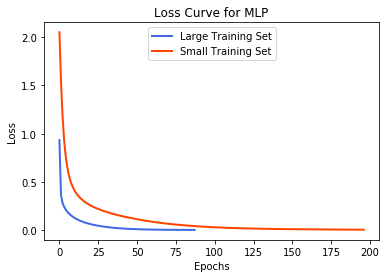

In [16]:
plt.title('Loss Curve for MLP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
mlp = MLPClassifier(solver='adam', activation='logistic')

train(mlp)
plt.plot(mlp.loss_curve_, label='Large Training Set', color='royalblue', lw=2)

train_small(mlp)
plt.plot(mlp.loss_curve_, label='Small Training Set', color='orangered', lw=2)

plt.legend(loc='upper center')
plt.show()

### Comparison With Logistic Regression, SVMs, and Naive Bayes
All three models had much higher classification accuracies than previous models, though this lead to slower training for the gradient boosting classifier and MLP. The random forest classifier stood out as a model with  high accuracy while still maintaining a reasonable training speed that was quicker than SVMs. 

The models also all have hyperparameters that require time to tune. However, they already work very well with no tuning, which suggest that a tuned model would be even more accurate. There was some overfitting with both dataset sizes, though this may have been caused by improper tuning.   

Ultimately, the decision once again comes down to accuracy vs computation, though different classifiers may work better with other types of problems so it is beneficial to try multiple models.  